In [7]:
# !pip install ta

In [152]:
import numpy as np
import pandas as pd

import yfinance as yf
import ta

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [153]:
stockCode = input("Enter ticker: ")

Enter ticker:  IONQ


In [154]:
ticker = yf.Ticker(stockCode)
price_hist = ticker.history(period="max", interval="1d")
price_hist.shape

(676, 7)

In [155]:
price_hist = price_hist.drop(columns=["Dividends", "Stock Splits"])

df = ta.add_momentum_ta(df=price_hist.copy(), high="High", low="Low", close="Close", volume="Volume")
df["PriceChange"] = df["Close"].shift(1) - df["Close"]
df["Target"] = np.where(df["PriceChange"] > 0, 1, 0)
df = df.dropna()

df.head()

,Open,High,Low,Close,Volume,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,PriceChange,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-26 00:00:00-05:00,13.34,14.80,12.60,14.47,1714800,67.825927,0.594228,0.615491,0.598350,37.922117,...,20.683908,4.657300,2.981509,1.675791,57.757033,31.020691,26.736342,12.606355,-1.350000,0
2021-03-01 00:00:00-05:00,14.61,14.84,13.70,14.60,959500,68.485740,0.621953,0.489476,0.523373,38.178829,...,22.895625,5.369995,3.459206,1.910789,48.781463,34.572845,14.208618,12.798306,-0.130000,0
2021-03-02 00:00:00-05:00,14.50,14.75,12.86,12.86,830100,52.860231,0.000000,0.405394,0.503454,30.804872,...,9.260825,4.791499,3.725665,1.065834,40.523412,35.762959,4.760453,12.799633,1.740001,1
2021-03-03 00:00:00-05:00,13.00,13.15,11.73,11.87,1067100,46.376796,0.000000,0.207318,0.367396,22.462138,...,0.593218,3.674633,3.715458,-0.040825,34.846303,35.579627,-0.733325,12.795288,0.990000,1
2021-03-04 00:00:00-05:00,11.95,12.15,10.86,11.97,1296400,47.082828,0.022698,0.007566,0.206759,17.095123,...,2.307696,2.815969,3.535561,-0.719591,31.352384,34.734179,-3.381795,12.789674,-0.100000,0


In [156]:
train_ratio = 0.6
test_ratio = 0.2

l = len(df)
train_idx = round(l * train_ratio)
test_idx = round(l * (train_ratio + test_ratio))

model_df = df.iloc[:test_idx, :]
valid_df = df.iloc[test_idx:, :]

print(model_df.shape, valid_df.shape)

(511, 25) (128, 25)


In [157]:
model_df.corr()

,Open,High,Low,Close,Volume,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,PriceChange,Target
Open,1.000000,0.994343,0.994004,0.987636,0.252090,0.287917,-0.097173,-0.065515,-0.049729,0.421422,...,0.322897,0.493012,0.528977,-0.011078,0.129398,0.146766,-0.001393,0.973535,0.062437,0.028119
High,0.994343,1.000000,0.990769,0.994312,0.305996,0.316072,-0.076448,-0.058333,-0.048117,0.434396,...,0.347643,0.500782,0.531965,0.004926,0.143636,0.157866,0.008930,0.968374,-0.007593,-0.002668
Low,0.994004,0.990769,1.000000,0.993670,0.207312,0.292861,-0.071979,-0.052893,-0.042135,0.406164,...,0.317175,0.483997,0.518318,-0.007890,0.105633,0.120518,-0.002604,0.975975,-0.002385,-0.007111
Close,0.987636,0.994312,0.993670,1.000000,0.264847,0.323781,-0.052164,-0.046750,-0.040316,0.425184,...,0.352109,0.497024,0.525138,0.013466,0.124923,0.137525,0.007296,0.968834,-0.081436,-0.042592
Volume,0.252090,0.305996,0.207312,0.264847,1.000000,0.223992,0.010707,-0.011210,-0.024122,0.226132,...,0.282966,0.144362,0.121667,0.097255,0.449721,0.359432,0.307750,0.204171,-0.135939,0.010836
momentum_rsi,0.287917,0.316072,0.292861,0.323781,0.223992,1.000000,0.501655,0.516513,0.507773,0.839624,...,0.801845,0.743288,0.578386,0.646086,0.223194,0.139550,0.233315,0.167609,-0.300377,-0.261307
momentum_stoch_rsi,-0.097173,-0.076448,-0.071979,-0.052164,0.010707,0.501655,1.000000,0.915664,0.790061,0.022815,...,0.466126,-0.001612,-0.214490,0.643570,-0.071741,-0.144670,0.132117,-0.190502,-0.331830,-0.429931
momentum_stoch_rsi_k,-0.065515,-0.058333,-0.052893,-0.046750,-0.011210,0.516513,0.915664,1.000000,0.953176,0.111435,...,0.528267,0.072797,-0.167531,0.741345,-0.056781,-0.136153,0.149492,-0.178688,-0.154145,-0.176773
momentum_stoch_rsi_d,-0.049729,-0.048117,-0.042135,-0.040316,-0.024122,0.507773,0.790061,0.953176,1.000000,0.186769,...,0.556909,0.138760,-0.108144,0.774305,-0.039070,-0.120736,0.158993,-0.160636,-0.085143,-0.057465
momentum_tsi,0.421422,0.434396,0.406164,0.425184,0.226132,0.839624,0.022815,0.111435,0.186769,1.000000,...,0.672552,0.906409,0.839765,0.381215,0.307460,0.266571,0.167158,0.332850,-0.071252,-0.010346


In [158]:
X = model_df.drop(columns=["PriceChange", "Target"])
y = model_df["Target"]

In [159]:
vif = pd.DataFrame()

vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by="VIF", ascending=False)

C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
21,momentum_pvo_hist,inf
20,momentum_pvo_signal,inf
19,momentum_pvo,inf
18,momentum_ppo_hist,inf
17,momentum_ppo_signal,inf
16,momentum_ppo,inf
1,High,452.160159
2,Low,424.363032
0,Open,356.394561
3,Close,351.946973


In [160]:
# X = X[["momentum_rsi", "momentum_tsi", "momentum_roc", "momentum_ao", "momentum_uo", "Volume"]]
X = X[["momentum_ao", "momentum_uo", "Volume"]]
X.corr()

,momentum_ao,momentum_uo,Volume
momentum_ao,1.000000,0.369819,0.242027
momentum_uo,0.369819,1.000000,0.058637
Volume,0.242027,0.058637,1.000000


In [161]:
## y_train = X_train["Target"]
X_train, X_test = X.iloc[:train_idx, :].values, X.iloc[train_idx:, :].values
y_train, y_test = y.values[:train_idx], y.values[train_idx:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(383, 3) (128, 3) (383,) (128,)


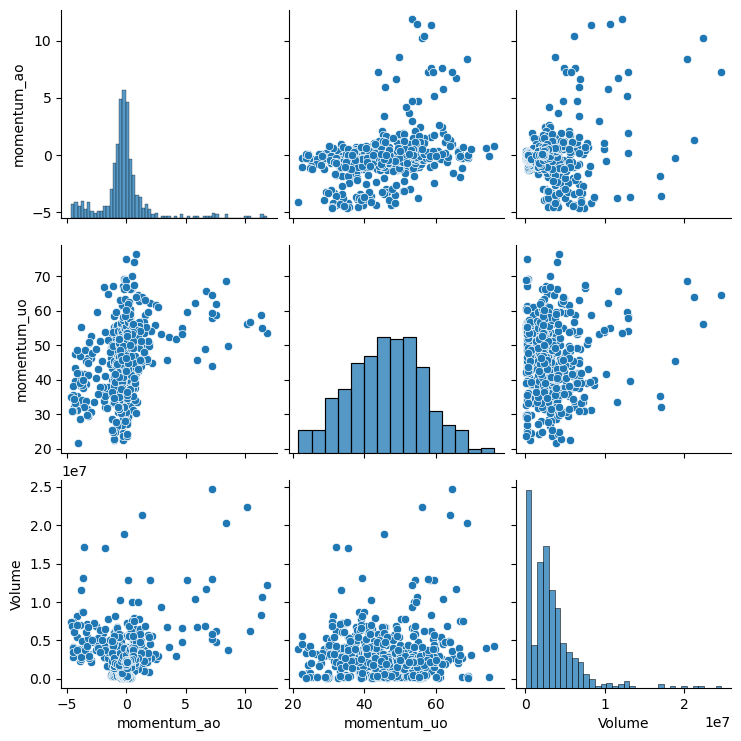

In [162]:
import seaborn as sns

sns.pairplot(X)

In [190]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<Axes: >

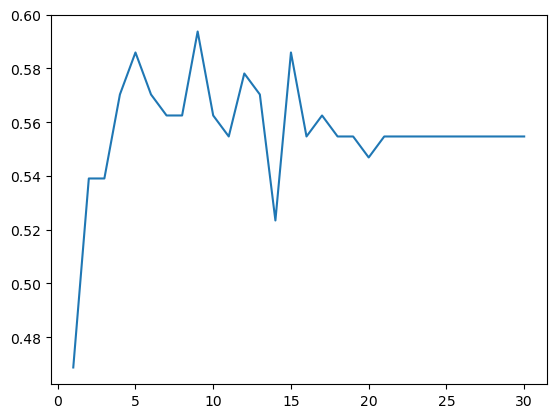

In [191]:
depth = np.arange(1, 31, 1)
score = []

for i in depth:
    _model = RandomForestClassifier(max_depth=i, random_state=123)
    _model.fit(X_std, y_train)
    _model_score = _model.score(X_test, y_test)
    score.append(_model_score)

sns.lineplot(x=depth, y=score)

In [192]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=9, random_state=123)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, random_state=123)

In [193]:
from sklearn.metrics import accuracy_score

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.59375


In [194]:
X_valid = valid_df[["momentum_ao", "momentum_uo", "Volume"]].values
y_valid = valid_df["Target"].values

y_valid_pred = rfc.predict(X_valid)
acc = accuracy_score(y_valid, y_valid_pred)
print(acc)

0.5078125
